In [1]:
from elm_autograd_physics_1d_to_3d import elm
import numpy as onp
import time
import jax.numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sys
from scipy.io import loadmat
import os 
import jax
jax.config.update("jax_enable_x64", True)
os.environ['CUDA_DEVICE_0_RDER'] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from scipy.special import roots_legendre, eval_legendre
import argparse

In [2]:
is_py = False
is_save = False




# Linear Bivariate PDE 

print("ROBER Problem >>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
# load test dataset


# Make collocation points
k1 = 0.04
k2 = 3*1e7
k3 = 1e4


from scipy.io import loadmat 
file = loadmat("dataset/rober_10001.mat")
# prev_start_idx = 0#2000#2000#0#12-1#0#12-1#0
# prev_end_idx =1001#2500#2001#14#12
# prev_result = loadmat(f"each_time_interval/[{prev_start_idx},{prev_end_idx}]_result.mat")
prev_result=None
start_idx = 0#12-1
end_idx = 1001#13 #among 51
X_test =file['t'].reshape(-1,1)[start_idx:end_idx,:]
U_test =file['y'].reshape(-1,3)[start_idx:end_idx,:]


tl = np.min(X_test)
tr = np.max(X_test)



ROBER Problem >>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [3]:
num_test_pts = U_test.shape[0]

if prev_result == None:
    x0 = 1.0
    y0 = 0.0
    z0 = 0.0
else:
    x0 = prev_result['x0']
    y0 = prev_result['y0']
    z0 = prev_result['z0']

def ROBER_PDE(u,t):
    x, y, z = u
    dxdt = - k1*x + k3 * y * z
    dydt =   k1*x - k3 * y * z - k2 * y**2
    dzdt =                       k2 * y**2
    return dxdt, dydt, dzdt

u0 = x0, y0, z0


plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth']=3
plt.rcParams['figure.figsize']=(10,8)

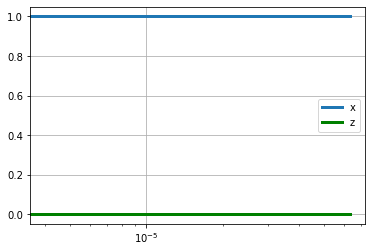

In [4]:
plt.figure()
plt.plot(X_test, U_test[:,0:1],label='x')
# plt.plot(X_test, U_test[:,1:2],label='y')
plt.plot(X_test, U_test[:,2:3],label='z',color='green')
# plt.plot(t, u, color='blue',linestyle='--' ,linewidth=1,label='ddeint')
plt.grid()
plt.legend()
plt.xscale("log")
# plt.xlim([1e-5,1e5])
if is_save:
    plt.savefig("figure/rober_goal_xz"+f"[{start_idx},{end_idx}].pdf",bbox_inches='tight')
else:
    plt.show()

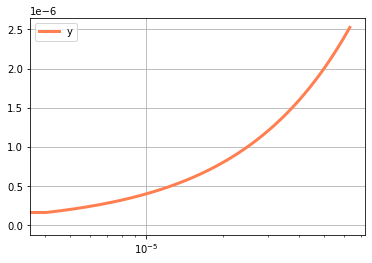

In [5]:
plt.figure()
plt.plot(X_test, U_test[:,1:2],label='y',color='coral')
plt.grid()
plt.legend()
plt.xscale("log")
# plt.xlim([1e-5,1e5])
if is_save:
    plt.savefig("figure/rober_goal_y"+f"[{start_idx},{end_idx}].pdf",bbox_inches='tight')
else:
    plt.show()

In [6]:
seed = int(time.time())
print('Colloc random seed:',seed)
onp.random.seed(seed)
N_colloc =15#15

roots= roots_legendre(N_colloc-2)[0].reshape(-1,1)
ts_ = (roots+1)/2*(tr-tl)+tl
# ts_ = np.random.uniform(tl,tr,N_colloc).reshape(-1,1)
# ts_ = np.linspace(tl,tr,N_colloc).reshape(-1,1)
X_colloc = np.concatenate([np.array([[tl]]),ts_,np.array([[tr]])],axis=0)
# X_colloc = np.logspace(np.log10(tl),np.log10(tr),N_colloc).reshape(-1,1)
U_colloc = np.zeros_like(X_colloc).repeat(3,1)


Colloc random seed: 1673441668


In [7]:
# build model and train

options = {
    0:{'C':1., 'alg':'no_re'},
    1:{'C':1e16, 'alg':'solution1'},
    2:{'C':1e16, 'alg':'solution2'}
    }
if is_py:
    parser = argparse.ArgumentParser()
    parser.add_argument('-opt_num',help='Option number',default=0)
    parser.add_argument('-act_func',help='Activation function',default='sin')
    args = parser.parse_args()
    opt_num = int(args.opt_num)
    act_func = args.act_func

    
else:
    opt_num = 0
    act_func = 'sin'
model = elm(x= X_colloc, y=U_colloc, C = options[opt_num]['C'],
            hidden_units=10, activation_function=act_func,
            random_type='uniform', elm_type='de',de_name='rober',
            quadrature =True,
            physic_param = [k1,k2,k3], initial_val = u0,
            random_seed = seed,Wscale=None, bscale=None,fourier_embedding=False)
if is_save:
    sys.stdout = open("logs/"+model.de_name+f"[{start_idx},{end_idx}](using_autograd)_result_method_{opt_num}_act_func_{model.activation_function}.txt",'w')

Random seed:  1673441668


model options:  {'elm_type': 'de', 'random_type': 'uniform', 'activation_function': 'sin', 'hidden_units': 10, 'C': 1.0, 'one_hot': False, 'physics_param': [0.04, 30000000.0, 10000.0], 'de_name': 'rober', 'tau': None, 'random_seed': 1673441668, 'fourier_embedding': False, 'initial_val': (1.0, 0.0, 0.0), 'quadrature': True}
N_colloc:  15
Train_score when iter=0: 0.021941843539084856
Train_score when iter=50: 8.7142239061123e-06
Train_score when iter=100: 1.8468711227384276e-06
Train_score when iter=150: 1.2972182091452258e-06
Train_score when iter=200: 1.290420033317324e-06
Train_score when iter=250: 1.289873354357307e-06
Train_score when iter=300: 1.2896419038549285e-06
Train_score when iter=350: 1.2894538188216055e-06
Train_score when iter=400: 1.2892735532518265e-06
Train_score when iter=450: 1.289094725212106e-06
Train_score when iter=500: 1.2889161888909661e-06
Train_score when iter=550: 1.2887377385561514e-06
Train_score when iter=600: 1.2885593372678481e-06
Train_score when iter=

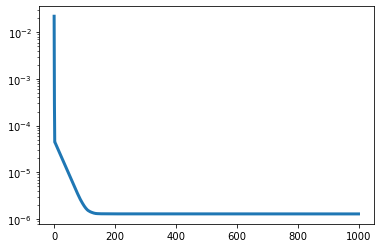

In [8]:
print("model options: ",model.option_dict)
print('N_colloc: ',N_colloc)

beta, train_score, running_time = model.fit(
    algorithm=options[opt_num]['alg'],
    num_iter =1000)#'no_re','solution1'
print("learned beta:\n", beta)
print("learned beta shape:\n", beta.shape)
print("test score:\n", train_score)
print("running time:\n", running_time)
plt.figure()
plt.semilogy(model.res_hist)

if is_save:
    plt.savefig("figure/"+model.de_name+f"[{start_idx},{end_idx}](using_autograd)_residual_history_method_{opt_num}_act_func_{model.activation_function}.pdf")
else:
    plt.show()

In [9]:

U_pred = model.predict(X_test)
print("predicted result: ", U_pred.shape)


err = np.abs(U_pred-U_test)
err = np.linalg.norm(err)/np.linalg.norm(U_test)
print("Relative L2-error norm: {}".format(err))

predicted result:  (1001, 3)
Relative L2-error norm: 3.92714026846219e-10


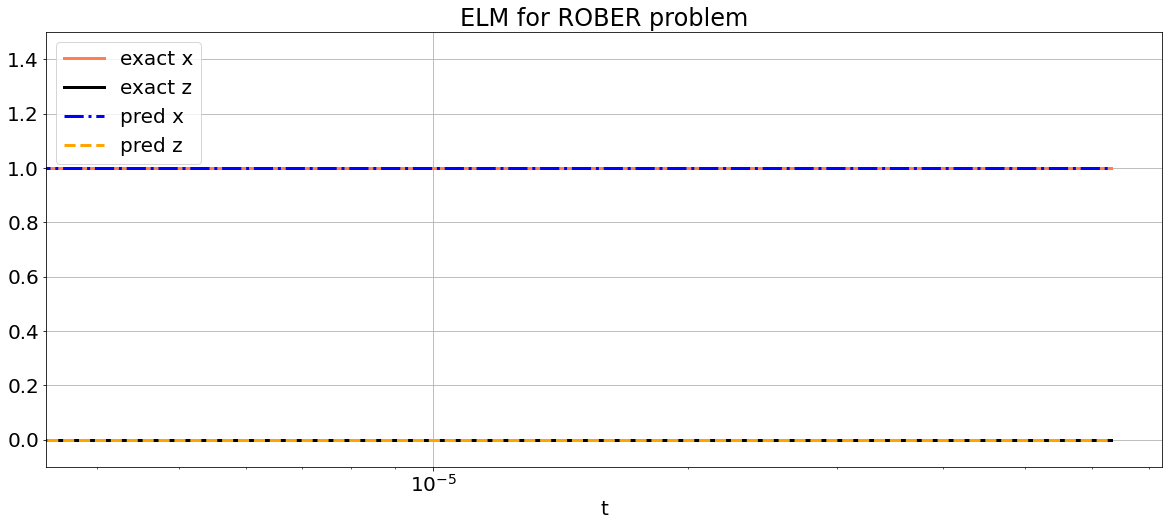

In [10]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth']=3
plt.rcParams['figure.figsize']=(20,8)
plt.figure( facecolor = 'white')
plt.title(f"ELM for ROBER problem")
plt.plot(X_test,U_test[:,0:1],color='coral',label='exact x')
# plt.plot(X_test,U_test[:,1:2],color = 'lightgreen',label='exact y')
plt.plot(X_test,U_test[:,2:3],'black',label='exact z')
plt.plot(X_test,U_pred[:,0:1],color='b',ls='dashdot',label='pred x')
# plt.plot(X_test,U_pred[:,1:2],'r',ls = 'dotted',label='pred y')
plt.plot(X_test,U_pred[:,2:3],'orange',ls='--',label='pred z')
plt.legend(loc=2)
plt.xscale("log")
plt.grid()
plt.ylim([-0.1,1.5])
plt.xlabel('t')


if is_save:
    plt.savefig("figure/"+model.de_name+f"[{start_idx},{end_idx}](using_autograd)xz_result_method_{opt_num}_act_func_{model.activation_function}.pdf")
else:
    plt.show()

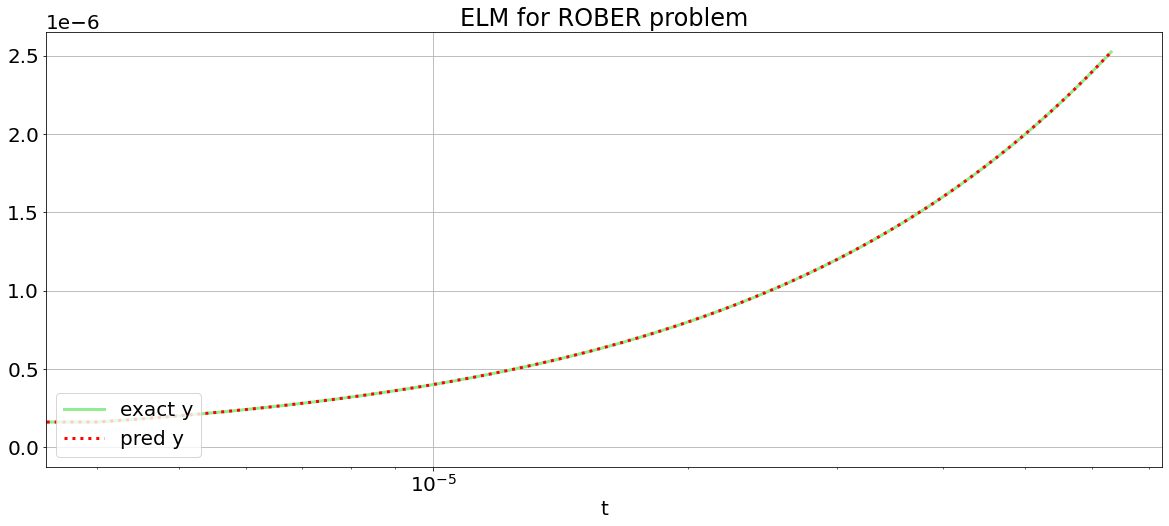

In [11]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth']=3
plt.rcParams['figure.figsize']=(20,8)
plt.figure(facecolor = 'white')
plt.title(f"ELM for ROBER problem")
# plt.plot(X_test,U_test[:,0:1],color='coral',label='exact x')
plt.plot(X_test,U_test[:,1:2],color = 'lightgreen',label='exact y')
# plt.plot(X_test,U_test[:,2:3],'black',label='exact z')
# plt.plot(X_test,U_pred[:,0:1],color='b',ls='dashdot',label='pred x')
plt.plot(X_test,U_pred[:,1:2],'r',ls = 'dotted',label='pred y')
# plt.plot(X_test,U_pred[:,2:3],'orange',ls='--',label='pred z')
plt.legend(loc=3)
plt.xscale("log")
# plt.ylim([-1e-5,1e-4])
plt.grid()
plt.xlabel('t')


if is_save:
    plt.savefig("figure/"+model.de_name+f"[{start_idx},{end_idx}](using_autograd)y_result_method_{opt_num}_act_func_{model.activation_function}.pdf")
else:
    plt.show()

In [12]:
print('U_test last: ',U_test[-1])
print('U_pred last: ',U_pred[-1])
if is_save:
    sys.stdout.close()

U_test last:  [9.99997470e-01 2.52467656e-06 4.85137408e-09]
U_pred last:  [9.99997470e-01 2.52548382e-06 4.06425165e-09]


In [13]:
from scipy.io import savemat
saving_dict = {}
saving_dict['t_final']=X_test[-1,0]
saving_dict['x0']=U_pred[-1,0].item()
saving_dict['y0']=U_pred[-1,1].item()
saving_dict['z0']=U_pred[-1,2].item()
saving_dict['tl']=tl
saving_dict['tr']=tr
saving_dict['start_idx']=start_idx
saving_dict['end_idx']=end_idx
saving_dict['X_test']=onp.array(X_test)
saving_dict['X_colloc']=onp.array(X_colloc)
saving_dict['U_test']=onp.array(U_test)
saving_dict['U_pred']=onp.array(U_pred)
saving_dict['W']= onp.array(model.W)
saving_dict['b']= onp.array(model.b)
saving_dict['beta']= onp.array(model.beta)
savemat("each_time_interval/"+f"[{start_idx},{end_idx}]_result.mat",saving_dict)


In [14]:
# so far result
prev_start_idxs = [0,2000,2499,2549,2599,2699,2799,2899,3000]#,2499]
prev_end_idxs =[2001,2500,2550,2600,2700,2800,2900,3001,3101]#,2550]

for i in range(len(prev_start_idxs)):
    prev_result = loadmat(f"each_time_interval/[{prev_start_idxs[i]},{prev_end_idxs[i]}]_result.mat")
    if i == 0:
        X_tests = prev_result['X_test']
        U_tests = prev_result['U_test'] 
        U_preds = prev_result['U_pred']
    else:
        X_tests = onp.concatenate([X_tests,prev_result['X_test'][:-1,:]],axis=0)
        U_tests = onp.concatenate([U_tests,prev_result['U_test'][:-1,:]],axis=0)
        U_preds = onp.concatenate([U_preds,prev_result['U_pred'][:-1,:]],axis=0)

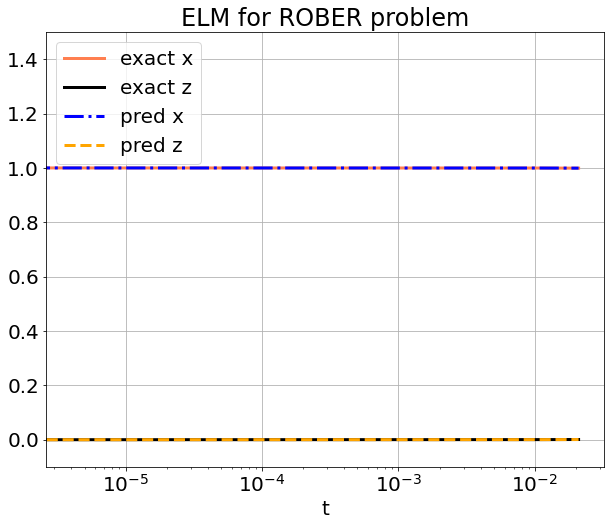

In [15]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth']=3
plt.figure(figsize=(10,8), facecolor = 'white')
plt.title(f"ELM for ROBER problem")
plt.plot(X_tests,U_tests[:,0:1],color='coral',label='exact x')
# plt.plot(X_test,U_test[:,1:2],color = 'lightgreen',label='exact y')
plt.plot(X_tests,U_tests[:,2:3],'black',label='exact z')
plt.plot(X_tests,U_preds[:,0:1],color='b',ls='dashdot',label='pred x')
# plt.plot(X_test,U_pred[:,1:2],'r',ls = 'dotted',label='pred y')
plt.plot(X_tests,U_preds[:,2:3],'orange',ls='--',label='pred z')
plt.legend(loc=2)
plt.xscale("log")
plt.grid()
plt.ylim([-0.1,1.5])
plt.xlabel('t')
if is_save:
    plt.savefig("figure/rober_whole_sol_xz(using_autograd)xz_result_method_{opt_num}_act_func_{model.activation_function}.pdf")
else:
    plt.show()

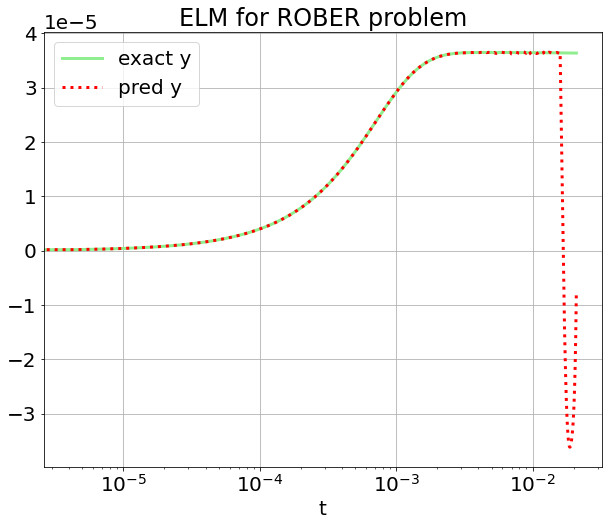

In [16]:
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth']=3
plt.figure(figsize=(10,8), facecolor = 'white')
plt.title(f"ELM for ROBER problem")
# plt.plot(X_test,U_test[:,0:1],color='coral',label='exact x')
plt.plot(X_tests,U_tests[:,1:2],color = 'lightgreen',label='exact y')
# plt.plot(X_test,U_test[:,2:3],'black',label='exact z')
# plt.plot(X_test,U_pred[:,0:1],color='b',ls='dashdot',label='pred x')
plt.plot(X_tests,U_preds[:,1:2],'r',ls = 'dotted',label='pred y')
# plt.plot(X_test,U_pred[:,2:3],'orange',ls='--',label='pred z')
plt.legend(loc=2)
plt.xscale("log")
# plt.ylim([-1e-5,1e-4])
plt.grid()
plt.xlabel('t')
if is_save:
    plt.savefig("figure/rober_whole_sol_y(using_autograd)xz_result_method_{opt_num}_act_func_{model.activation_function}.pdf")
else:
    plt.show()
